# Probability of blackout , a Kenyan story

In [1]:
!git clone https://github.com/Yuri-Njathi/impact-of-planned-vs-unplanned-power-interruptions

Cloning into 'impact-of-planned-vs-unplanned-power-interruptions'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 414 (delta 128), reused 0 (delta 0), pack-reused 222 (from 2)
Receiving objects: 100% (414/414), 5.41 MiB | 15.06 MiB/s, done.
Resolving deltas: 100% (273/273), done.


In [2]:
import sys
sys.path.append("impact-of-planned-vs-unplanned-power-interruptions")

In [3]:
!pip install osmnx
import fynesse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.14.4
    Uninstalling geopandas-0.14.4:
      Successfully uninstalled geopandas-0.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [4]:
# Import the Fynesse framework
import fynesse
from fynesse import access, assess, address

# Import common data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Fynesse framework imported successfully")
print(f"📦 Framework version: {fynesse.__version__ if hasattr(fynesse, '__version__') else 'Development'}")

✅ Fynesse framework imported successfully
📦 Framework version: Development


---

## Phase 1: Access - Data Acquisition

The first phase involves gaining access to your data, including handling legal, ethical, and availability challenges.


The data used in this study was obtained from 3 sources:
1.  Number of electrified households from Kenya census data.
2.  Dataset on planned outages in Kenya per county, from KPLC website as pdfs, then extracted the text using `regex` and `pypdf2`. The period covered is 27th October 2023 to 27th September 2025.
3.  Data on Kenyan grid reliability indices from EPRA annual reports with SAIDI, SAIFI and CAIDI data from July 2023 - Dec 2024

This study time overlap is November 2023 to December 2024 but the planned outage data can also answer questions on it's own.

Here I try and answer a few of these questions

In [5]:
# Load data using the access module
print("🔍 Loading data from access module...")
data = access.epra_data()

if data is not None:
    print(f"✅ Data loaded successfully: {len(data)} rows, {len(data.columns)} columns")
    print(f"📊 Data types: {data.dtypes.value_counts().to_dict()}")
else:
    print("❌ No data available. Please check your data source configuration.")
    print("💡 Tip: Update fynesse/defaults.yml with your data source information")

🔍 Loading data from access module...
✅ Data loaded successfully: 18 rows, 9 columns
📊 Data types: {dtype('float64'): 4, dtype('O'): 3, dtype('int64'): 2}


In [6]:
epra_data, kplc_data = access.epra_data(), access.census_kplc_data()

## 1. How many Kenyan households are connected to electricity?

In [7]:
NT = kplc_data.groupby("CODE")["electrified_households"].mean().reset_index().sum()['electrified_households']
print(NT)

6066173.0


6,066,173 Kenyan households are connected to electricity

## 2. Which Kenyan counties are most and least connected to electricity?

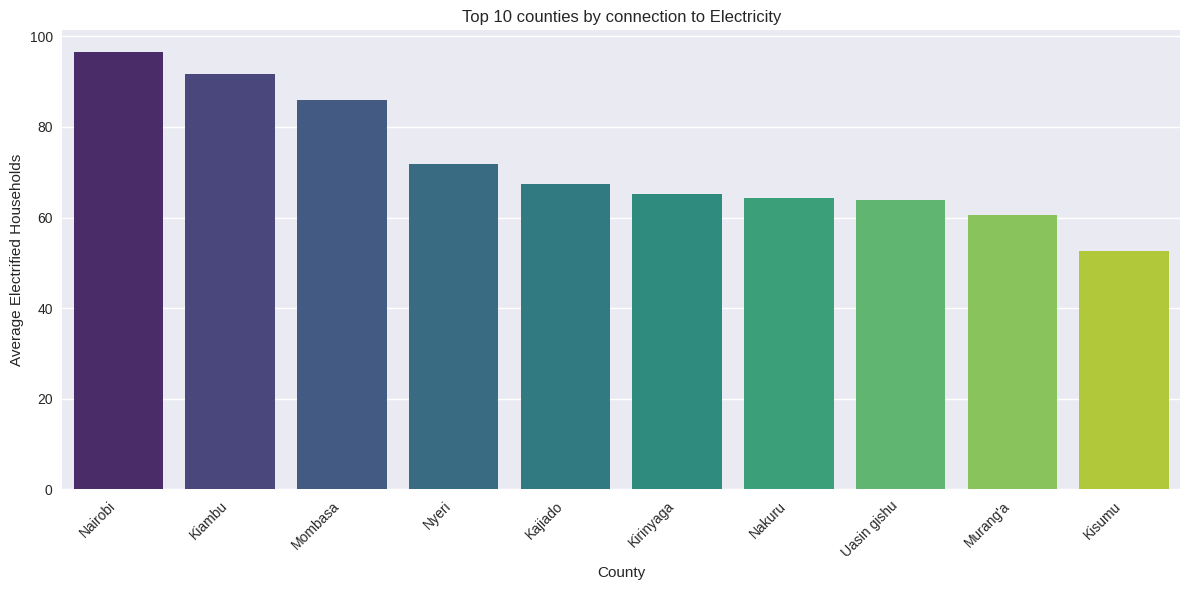

In [8]:
mean_electricity = kplc_data.groupby("CODE")["Mains Electricity"].mean().reset_index()
county_to_code, code_to_county = access.get_code_county_maps()
mean_electricity["CODE"] = mean_electricity["CODE"].apply(lambda x: str(x).zfill(3))
mean_electricity['County'] = mean_electricity["CODE"].map(code_to_county).str.capitalize()
assess.plot_series(s=mean_electricity.sort_values(by="Mains Electricity", ascending=False)[:10],x="County",y="Mains Electricity",title="Top 10 counties by connection to Electricity",ylabel="Average Electrified Households",xlabel="County")

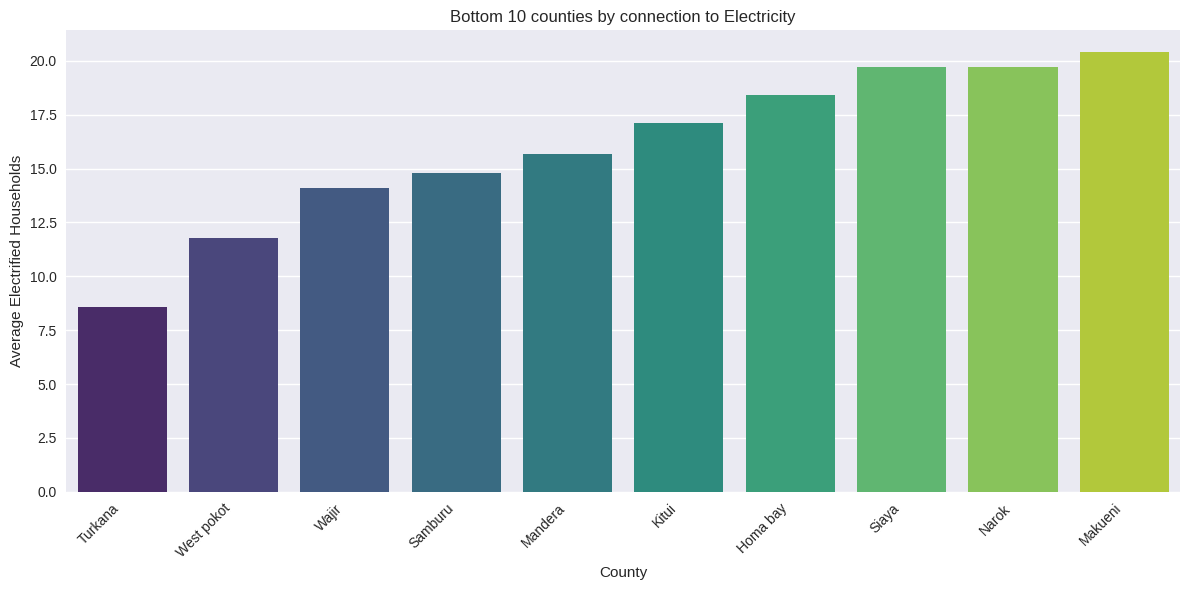

In [9]:
assess.plot_series(s=mean_electricity.sort_values(by="Mains Electricity", ascending=True)[:10],x="County",y="Mains Electricity",title="Bottom 10 counties by connection to Electricity",ylabel="Average Electrified Households",xlabel="County")

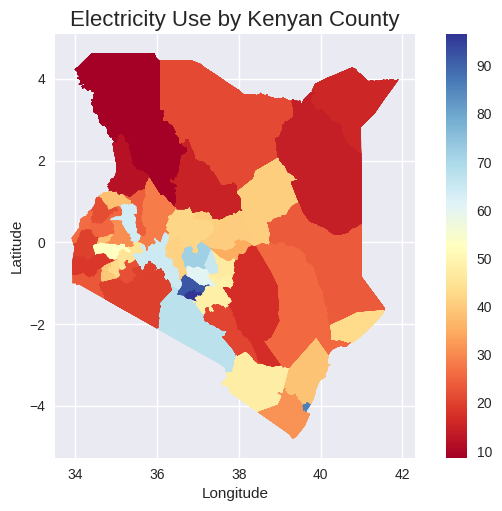

In [10]:
#Kenyan Map
gdf_counties, gdf, kenya_poly = assess.get_kenyan_maps()
assess.get_kenyan_map_with_electricity(gdf_counties, gdf, kenya_poly)

### Seems like the southern hemisphere is better electrified (global south) :D

## 3. How many times does the average Kenyan household lose power per month?

In [11]:
epra_data['SAIFI'].mean(),epra_data['SAIFI'].max(),epra_data['SAIFI'].min()

(3.8316666666666666, 5.03, 2.81)

### 4 times a month (average) , once a week

## 4. When lights go off, how long does it usually last?

In [12]:
epra_data['CAIDI'].mean(),epra_data['CAIDI'].max(),epra_data['CAIDI'].min()

(2.536111111111111, 3.4, 2.0)

## 2 and a half hours

## 5. How many hours in a month a Kenyan household without power?

In [13]:
epra_data['SAIDI'].mean(),epra_data['SAIDI'].max(),epra_data['SAIDI'].min()

(9.786111111111111, 17.3, 5.5)

## about 10 hours

---

## Phase 2: Assess - Data Quality Assessment

The second phase involves understanding data quality and characteristics without preconceived questions.

In [14]:
# Assess data quality using the assess module
print("🔍 Assessing data quality...")
assessed_data = assess.census_kplc_data()

if assessed_data is not None:
    print(f"✅ Data assessment completed: {len(assessed_data)} rows, {len(assessed_data.columns)} columns")
    
    # Display basic data quality metrics
    print("\n📈 Data Quality Summary:")
    print(f"   • Missing values: {assessed_data.isnull().sum().sum()} total")
    print(f"   • Duplicate rows: {assessed_data.duplicated().sum()}")
    print(f"   • Memory usage: {assessed_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
else:
    print("❌ Data assessment failed. Check the assess module implementation.")

🔍 Assessing data quality...
✅ Data assessment completed: 389 rows, 19 columns

📈 Data Quality Summary:
   • Missing values: 10 total
   • Duplicate rows: 0
   • Memory usage: 0.14 MB


### Data Quality Visualization

/tmp/ipykernel_13/3958536302.py:32: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  assessed_data[numeric_cols[:3]].hist(ax=axes[1,1], bins=20)


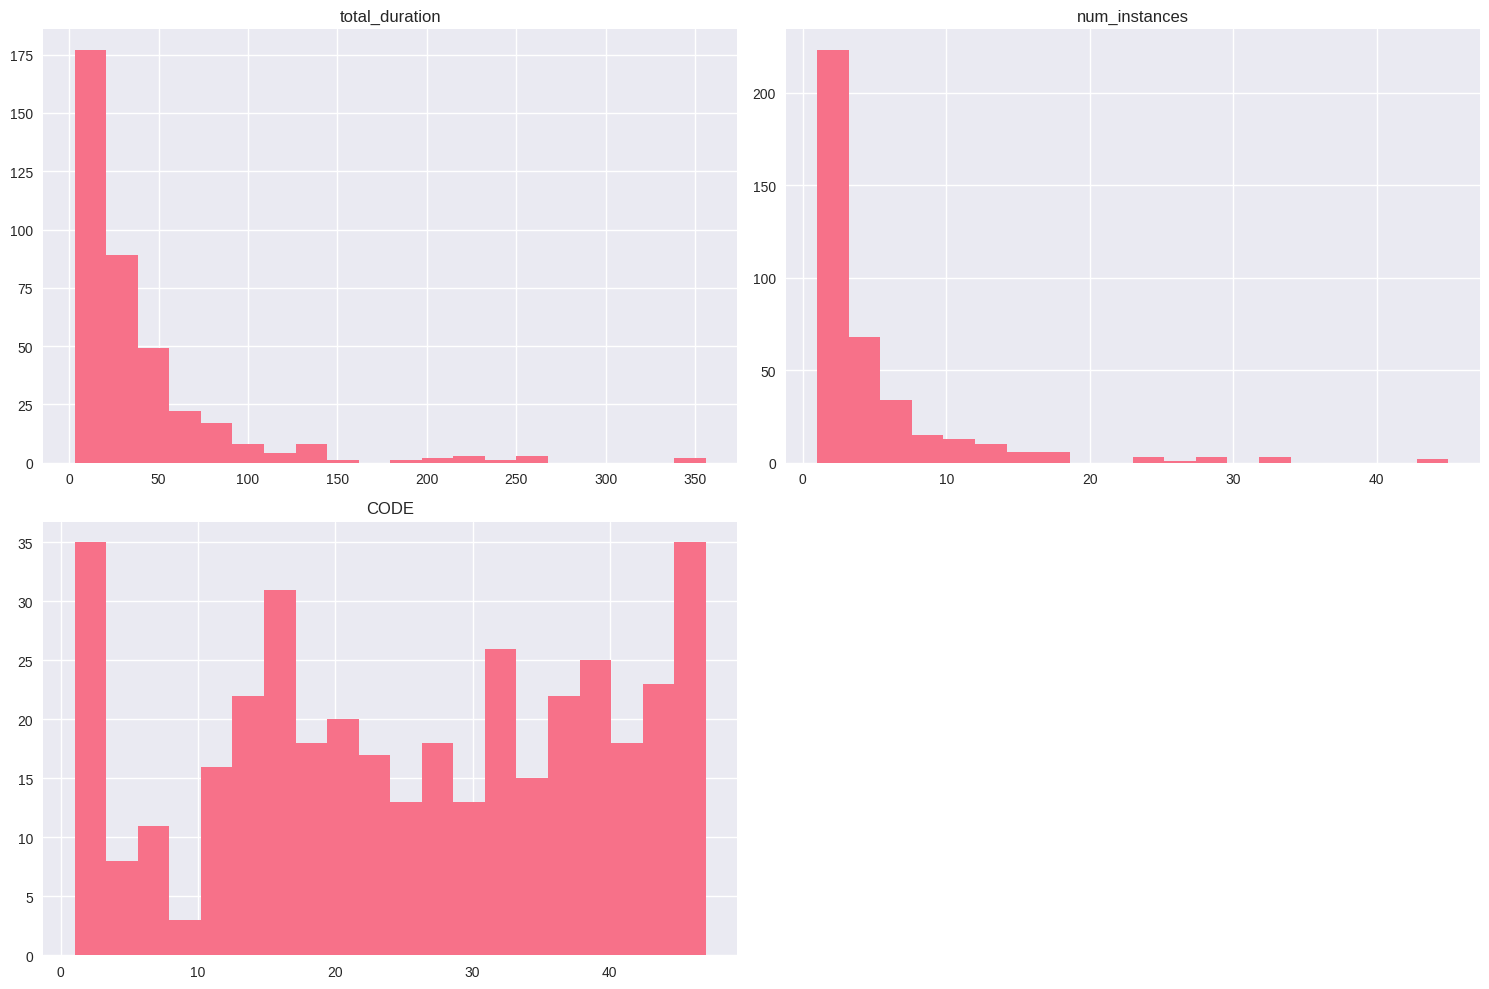

In [15]:
# Visualize data quality issues
if assessed_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Missing values heatmap
    missing_data = assessed_data.isnull()
    if missing_data.any().any():
        sns.heatmap(missing_data, cbar=True, ax=axes[0,0])
        axes[0,0].set_title('Missing Values Heatmap')
    else:
        axes[0,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Missing Values Heatmap')
    
    # Data types distribution
    data_types = assessed_data.dtypes.value_counts()
    axes[0,1].pie(data_types.values, labels=data_types.index, autopct='%1.1f%%')
    axes[0,1].set_title('Data Types Distribution')
    
    # Column-wise missing values
    missing_counts = assessed_data.isnull().sum()
    if missing_counts.sum() > 0:
        missing_counts[missing_counts > 0].plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Missing Values by Column')
        axes[1,0].tick_params(axis='x', rotation=45)
    else:
        axes[1,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Missing Values by Column')
    
    # Numeric data distribution (if available)
    numeric_cols = assessed_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        assessed_data[numeric_cols[:3]].hist(ax=axes[1,1], bins=20)
        axes[1,1].set_title('Numeric Data Distribution')
    else:
        axes[1,1].text(0.5, 0.5, 'No Numeric Columns', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Numeric Data Distribution')
    
    plt.tight_layout()
    plt.show()

## 6. As per Q3, you'll experience about 4 interruptions per month, how many of these are planned interruptions?

In [16]:
interruptions_per_county = kplc_data.groupby("county")["num_instances"].mean().reset_index()
kenyan_avg = interruptions_per_county["num_instances"].mean()
print(kenyan_avg)

3.9586898286898284


In [17]:
interruptions_per_county["county"] = interruptions_per_county["county"].str.capitalize()

### As per the data each of the 4 interruptions would be caused by planned interruptions on average

## 7. Which counties experience more vs less planned interruptions?

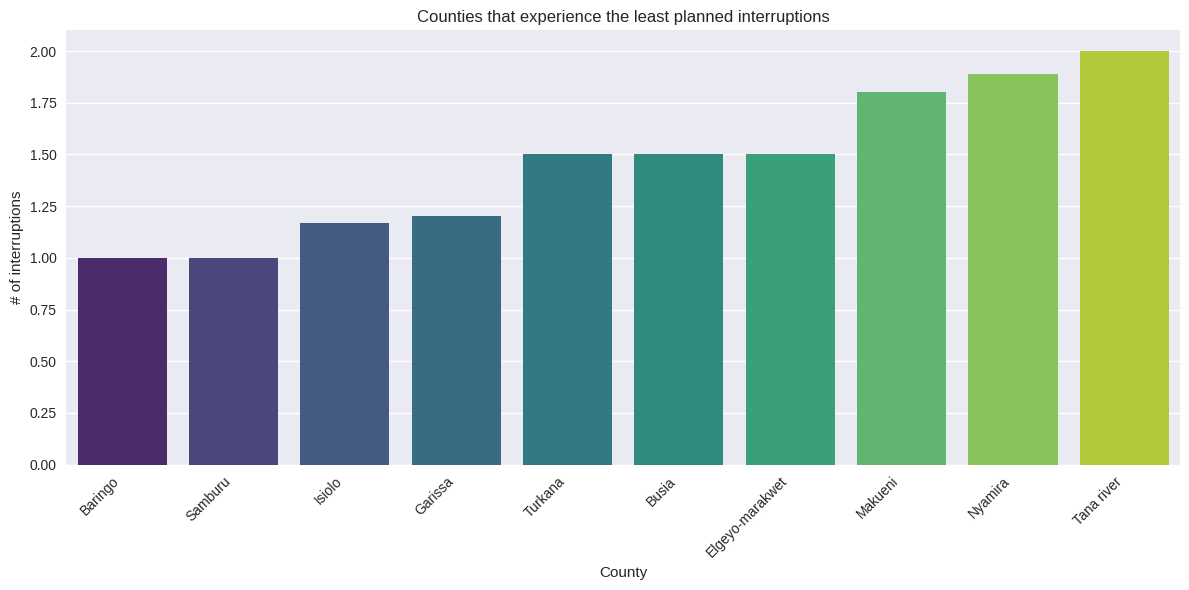

In [18]:
assess.plot_series(s=interruptions_per_county.sort_values(by="num_instances", ascending=True)[:10],x="county",y="num_instances",title="Counties that experience the least planned interruptions",ylabel="# of interruptions",xlabel="County")

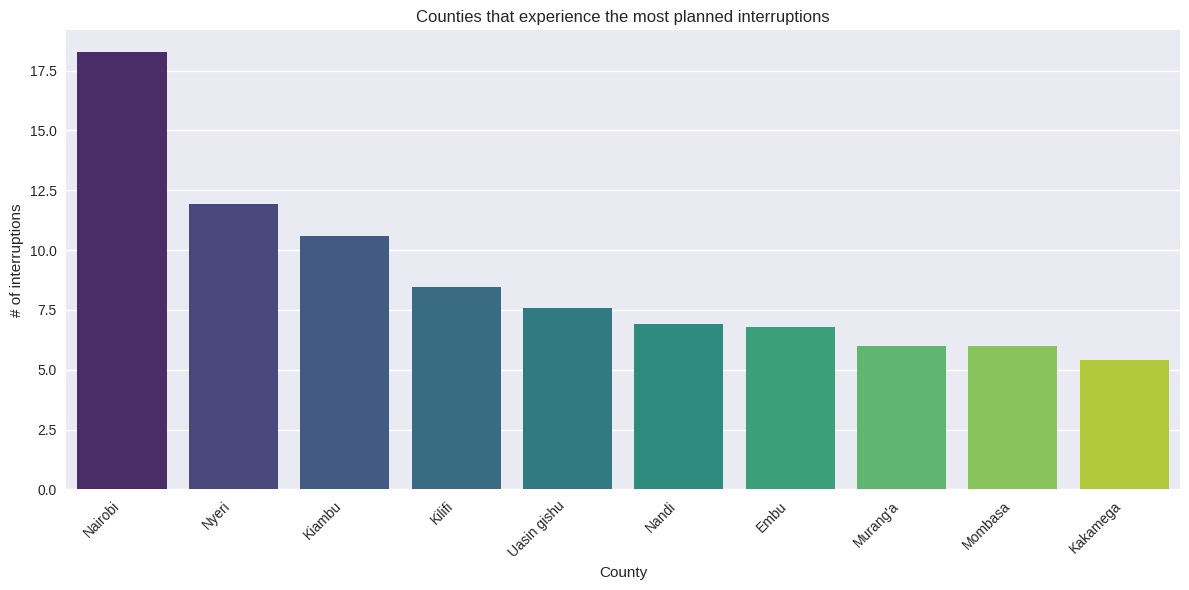

In [19]:
assess.plot_series(s=interruptions_per_county.sort_values(by="num_instances", ascending=not True)[:10],x="county",y="num_instances",title="Counties that experience the most planned interruptions",ylabel="# of interruptions",xlabel="County")

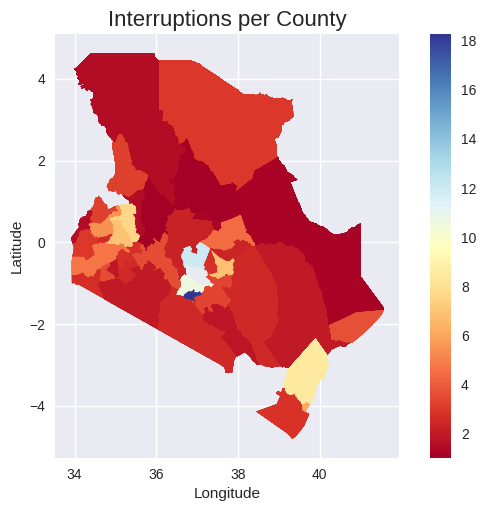

In [20]:
assess.get_kenyan_map_with_series(df=interruptions_per_county,gdf_counties=gdf_counties, gdf=gdf, kenya_poly=kenya_poly,title="Interruptions per County",col="num_instances")

## 8. Which day of the week has most planned interruptions?

In [21]:
kplc_only_data = access.kplc_data()
# Count interruptions per day
interruptions_per_day = kplc_only_data["day_of_week"].value_counts().reset_index()
interruptions_per_day.columns = ["day_of_week", "interruptions"]
interruptions_per_day

,day_of_week,interruptions
0,Thursday,456
1,Tuesday,449
2,Wednesday,372
3,Sunday,194
4,Monday,173
5,Friday,151
6,Saturday,86


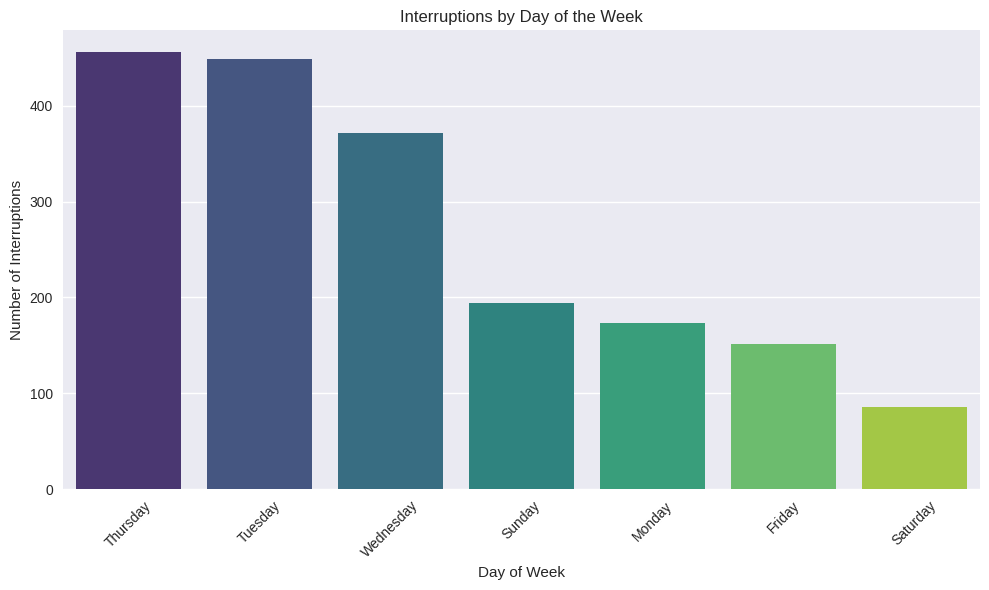

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=interruptions_per_day, x="day_of_week", y="interruptions", palette="viridis")
plt.title("Interruptions by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Interruptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Make sure 'duration_hours' is numeric
kplc_only_data['duration_hours'] = pd.to_numeric(kplc_only_data['duration_hours'], errors='coerce')

# Group by day_of_week and sum the duration
duration_by_day = kplc_only_data.groupby('day_of_week')['duration_hours'].sum().reset_index()

# Optional: sort days in natural order
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
duration_by_day['day_of_week'] = pd.Categorical(duration_by_day['day_of_week'], categories=days_order, ordered=True)
duration_by_day = duration_by_day.sort_values('day_of_week')

print(duration_by_day)

  day_of_week  duration_hours
1      Monday     1380.000000
5     Tuesday     3540.083333
6   Wednesday     2937.000000
4    Thursday     3611.583333
0      Friday     1192.250000
2    Saturday      681.000000
3      Sunday     1513.000000


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


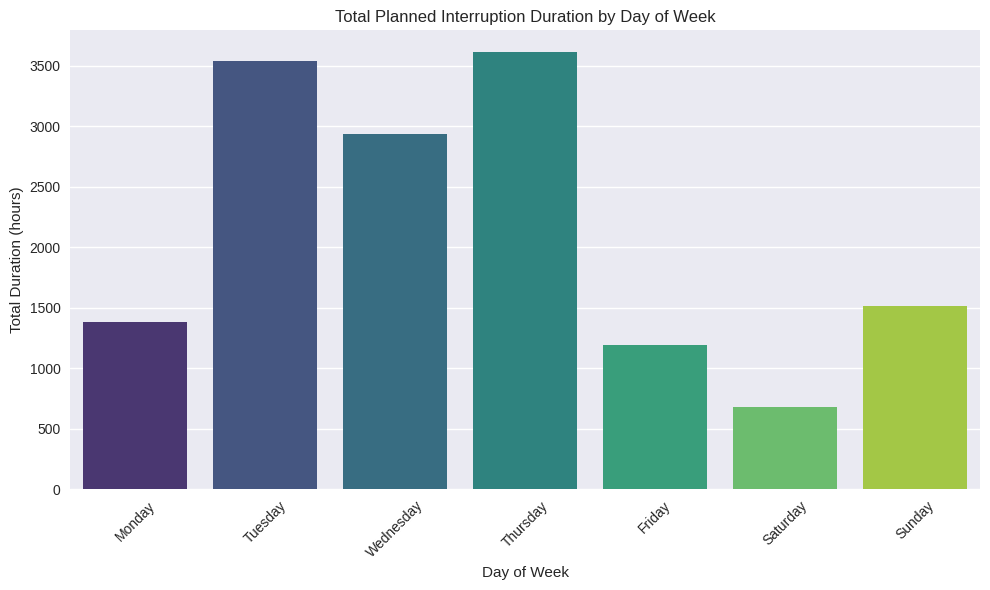

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(data=duration_by_day, x='day_of_week', y='duration_hours', palette='viridis')
plt.title('Total Planned Interruption Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Thursdays, Tuesdays and Wednesdays experience most planned interruptions

---

## Phase 3: Address - Question Answering

The third phase involves answering specific questions using the assessed data, including modeling and visualization.

In [25]:
# Analyze data using the address module
print("🔍 Analyzing data to address specific questions...")
analysis_results = address.analyze_data(assessed_data)

if 'error' not in analysis_results:
    print("✅ Data analysis completed successfully")
    print(f"📊 Sample size: {analysis_results.get('sample_size', 'N/A')}")
    print(f"📋 Columns analyzed: {len(analysis_results.get('columns', []))}")
    print(f"🔍 Analysis complete: {analysis_results.get('analysis_complete', False)}")
else:
    print(f"❌ Analysis failed: {analysis_results.get('error', 'Unknown error')}")

🔍 Analyzing data to address specific questions...
Analysis completed. Sample size: 389
✅ Data analysis completed successfully
📊 Sample size: 389
📋 Columns analyzed: 19
🔍 Analysis complete: True


### Analysis Results Visualization

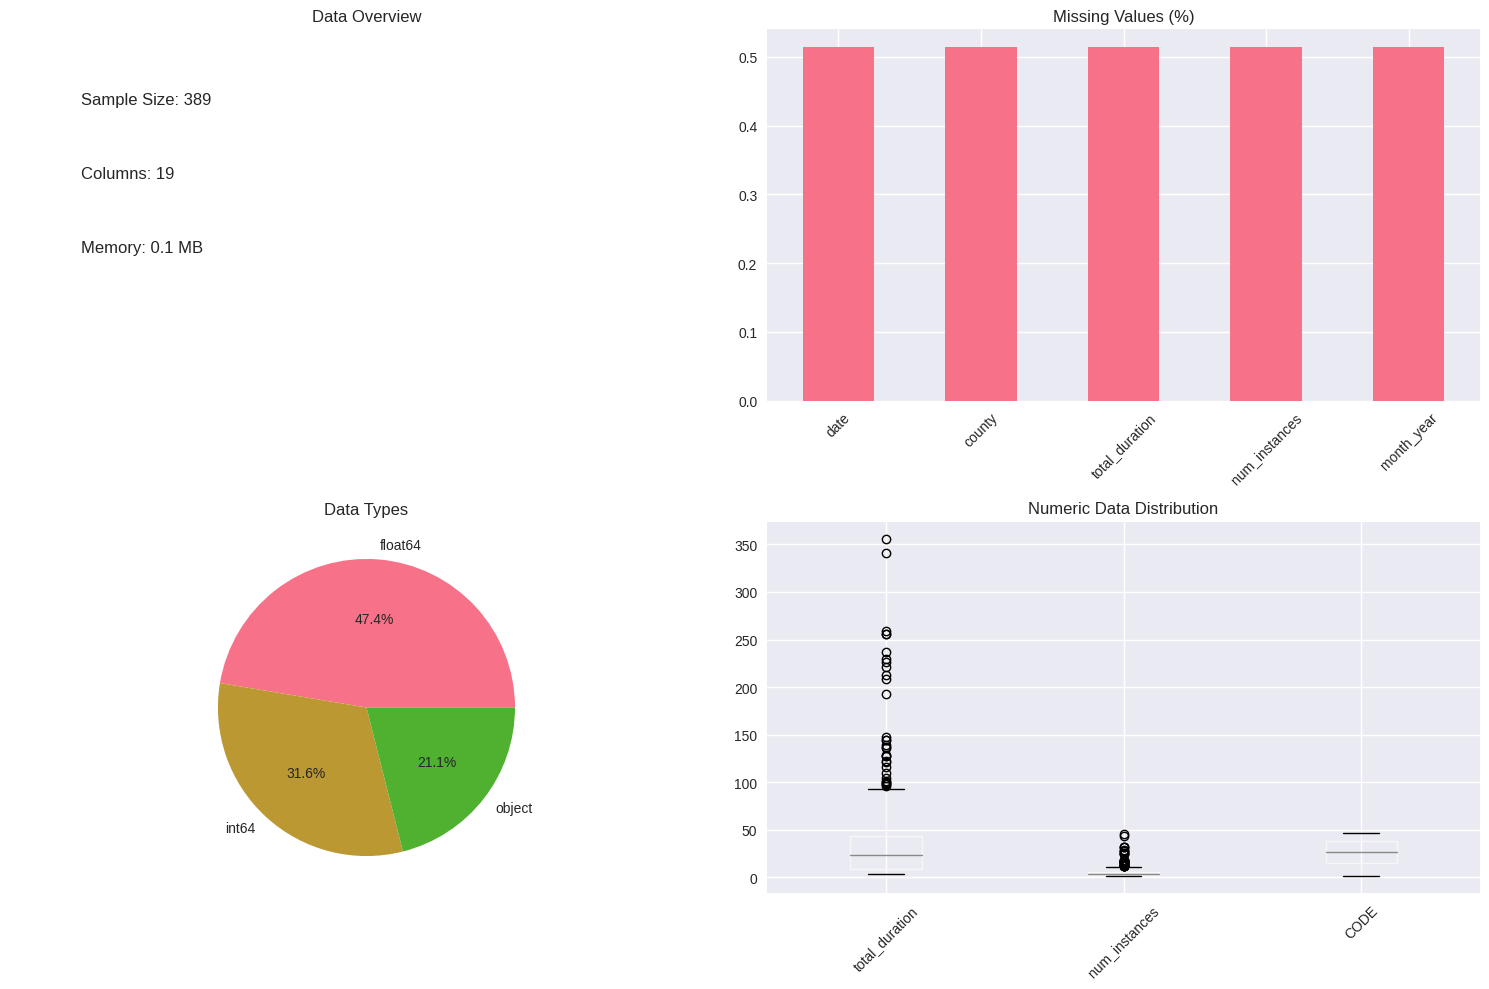

In [26]:
# Display analysis results
if 'error' not in analysis_results and assessed_data is not None:
    # Create summary visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Data overview
    axes[0,0].text(0.1, 0.8, f'Sample Size: {len(assessed_data)}', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].text(0.1, 0.6, f'Columns: {len(assessed_data.columns)}', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].text(0.1, 0.4, f'Memory: {assessed_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].set_title('Data Overview')
    axes[0,0].axis('off')
    
    # Missing values summary
    missing_pct = (assessed_data.isnull().sum() / len(assessed_data)) * 100
    if missing_pct.sum() > 0:
        missing_pct[missing_pct > 0].plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Missing Values (%)')
        axes[0,1].tick_params(axis='x', rotation=45)
    else:
        axes[0,1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Missing Values (%)')
    
    # Data types
    data_types = assessed_data.dtypes.value_counts()
    axes[1,0].pie(data_types.values, labels=data_types.index, autopct='%1.1f%%')
    axes[1,0].set_title('Data Types')
    
    # Numeric summary (if available)
    numeric_cols = assessed_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        assessed_data[numeric_cols[:3]].boxplot(ax=axes[1,1])
        axes[1,1].set_title('Numeric Data Distribution')
        axes[1,1].tick_params(axis='x', rotation=45)
    else:
        axes[1,1].text(0.5, 0.5, 'No Numeric Columns', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Numeric Data Distribution')
    
    plt.tight_layout()
    plt.show()

## 9. What is the relationship between the indexes and the planned interruptions

In [27]:
kplc_data

,date,county,total_duration,num_instances,month_year,CODE,Conventional Households,Mains Electricity,UNIT_AREA,UNIT_PERIM,COUNT,COUNTY_NAM,TOTAL_POP,POP_DENSIT,Latitude,Longitude,CHME,PPH,electrified_households
0,2024-09-30,mombasa,16.0,2.0,2024-09,1,376295,85.9,0.023356,0.967209,34,Mombasa,1208333,517.354427,-4.0435,40.0000,323237,3.0,323237
1,2024-10-31,mombasa,8.0,1.0,2024-10,1,376295,85.9,0.023356,0.967209,34,Mombasa,1208333,517.354427,-4.0435,40.0000,323237,3.0,323237
2,2024-12-31,mombasa,24.0,3.0,2024-12,1,376295,85.9,0.023356,0.967209,34,Mombasa,1208333,517.354427,-4.0435,40.0000,323237,3.0,323237
3,2025-01-31,mombasa,40.0,5.0,2025-01,1,376295,85.9,0.023356,0.967209,34,Mombasa,1208333,517.354427,-4.0435,40.0000,323237,3.0,323237
4,2025-02-28,mombasa,20.0,3.0,2025-02,1,376295,85.9,0.023356,0.967209,34,Mombasa,1208333,517.354427,-4.0435,40.0000,323237,3.0,323237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,2025-05-31,nairobi,256.0,32.0,2025-05,47,1494676,96.5,0.057502,1.688550,107,Nairobi,4397073,764.681750,-1.2864,36.8172,1442362,3.0,1442362
385,2025-06-30,nairobi,40.0,5.0,2025-06,47,1494676,96.5,0.057502,1.688550,107,Nairobi,4397073,764.681750,-1.2864,36.8172,1442362,3.0,1442362
386,2025-07-31,nairobi,256.0,32.0,2025-07,47,1494676,96.5,0.057502,1.688550,107,Nairobi,4397073,764.681750,-1.2864,36.8172,1442362,3.0,1442362
387,2025-08-31,nairobi,237.0,28.0,2025-08,47,1494676,96.5,0.057502,1.688550,107,Nairobi,4397073,764.681750,-1.2864,36.8172,1442362,3.0,1442362


In [28]:
interruptions_per_month = kplc_data.groupby("month_year")["num_instances"].sum().reset_index()
interruptions_per_month

,month_year,num_instances
0,2023-10,1.0
1,2024-01,1.0
2,2024-06,8.0
3,2024-07,19.0
4,2024-08,1.0
5,2024-09,190.0
6,2024-10,80.0
7,2024-11,52.0
8,2024-12,62.0
9,2025-01,117.0


In [29]:
duration_of_interruptions_per_month = kplc_data.groupby("month_year")["total_duration"].sum().reset_index()
duration_of_interruptions_per_month

,month_year,total_duration
0,2023-10,9.000000
1,2024-01,8.000000
2,2024-06,52.000000
3,2024-07,150.500000
4,2024-08,7.000000
5,2024-09,1462.500000
6,2024-10,612.500000
7,2024-11,393.500000
8,2024-12,473.750000
9,2025-01,923.083333


In [30]:
diipm = interruptions_per_month.merge(duration_of_interruptions_per_month, on="month_year", how="outer")

In [31]:
counties_merged = diipm.merge(epra_data, left_on="month_year", right_on="month_year_fmt", how="outer")
counties_merged[['num_instances','total_duration','SAIDI','CAIDI','SAIFI']]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,num_instances,total_duration,SAIDI,CAIDI,SAIFI
0,NaN,NaN,5.50,2.000,2.81
1,NaN,NaN,8.60,2.600,3.28
2,NaN,NaN,11.10,2.200,4.99
3,1.0,9.000000,8.10,2.200,3.64
4,NaN,NaN,10.70,2.400,4.50
5,NaN,NaN,8.90,2.300,3.97
6,1.0,8.000000,8.80,2.500,3.44
7,NaN,NaN,9.30,2.300,4.00
8,NaN,NaN,11.40,2.600,4.36
9,NaN,NaN,17.30,3.400,5.03


In [32]:
corr_matrix = counties_merged[['num_instances','total_duration','SAIDI','CAIDI','SAIFI']].corr()
corr_matrix

,num_instances,total_duration,SAIDI,CAIDI,SAIFI
num_instances,1.000000,0.999664,0.500724,0.094683,0.549615
total_duration,0.999664,1.000000,0.498993,0.088664,0.551143
SAIDI,0.500724,0.498993,1.000000,0.803502,0.853423
CAIDI,0.094683,0.088664,0.803502,1.000000,0.396064
SAIFI,0.549615,0.551143,0.853423,0.396064,1.000000


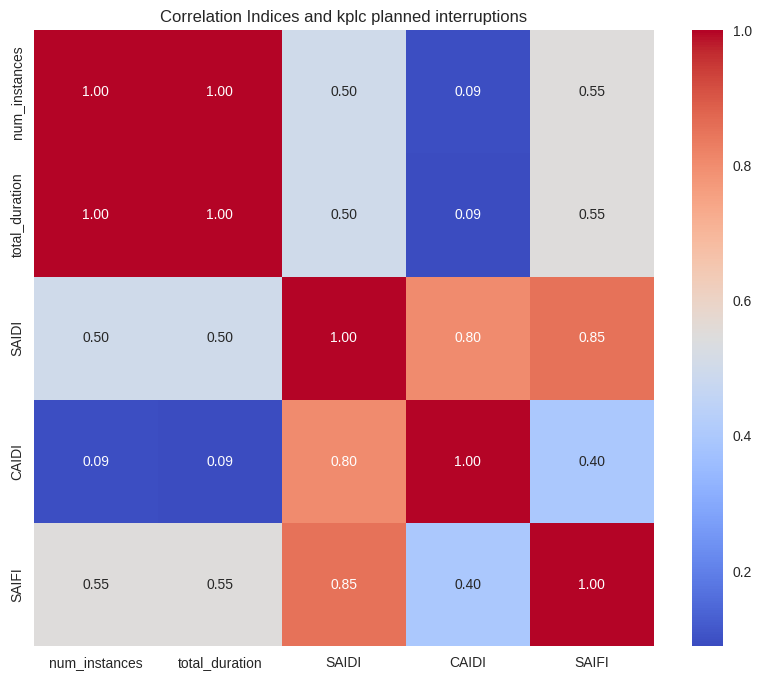

In [33]:
# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Indices and kplc planned interruptions")
plt.show()


Number of instances and duraion of instances has a +ve correlation of 0.5

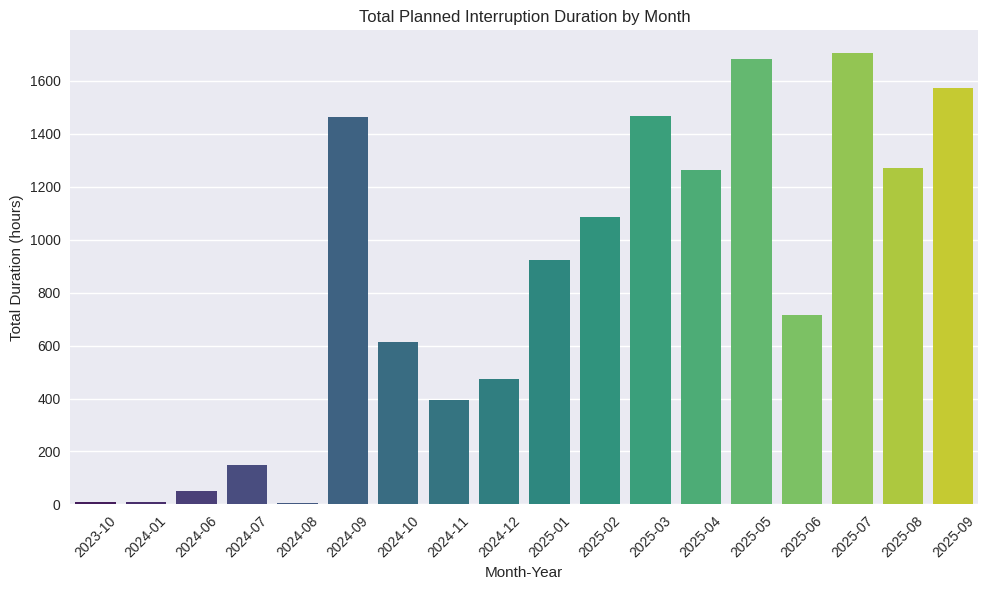

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(data=duration_of_interruptions_per_month, x="month_year", y="total_duration", palette="viridis")
plt.title("Total Planned Interruption Duration by Month")
plt.xlabel("Month-Year")
plt.ylabel("Total Duration (hours)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


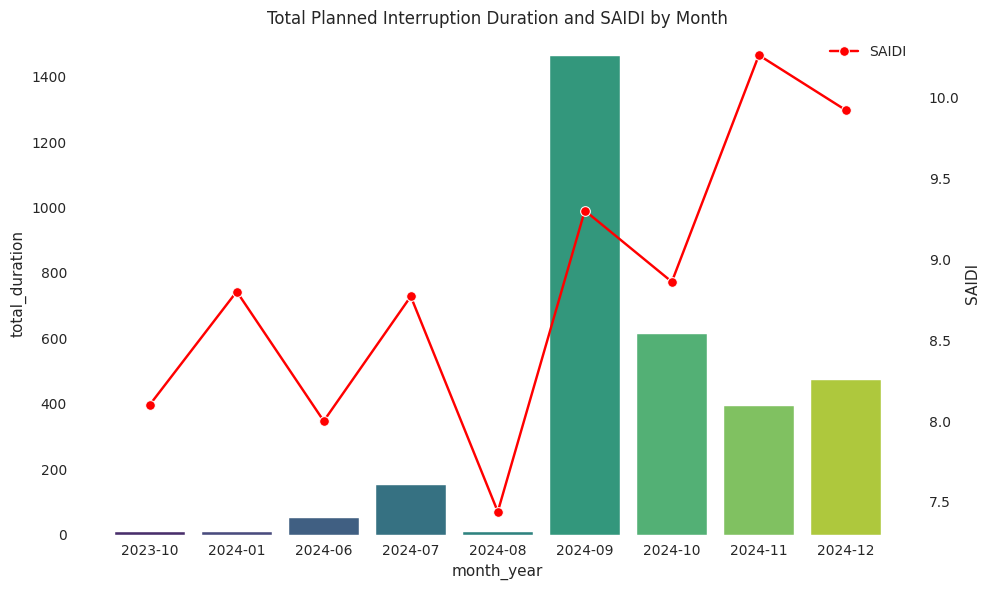

In [35]:
counties_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
counties_merged.dropna(subset=["total_duration", "SAIDI"], inplace=True)
plt.figure(figsize=(10,6))

# Remove grid
sns.set_style("white")  # removes background grid

# Barplot for total duration
sns.barplot(data=counties_merged,x="month_year",y="total_duration",palette="viridis")

# Create secondary axis for SAIDI
ax2 = plt.twinx()

# Line plot for SAIDI
sns.lineplot(data=counties_merged,x="month_year",y="SAIDI",marker="o",color="red",label="SAIDI",ax=ax2)

# Titles and labels
plt.title("Total Planned Interruption Duration and SAIDI by Month")
plt.xlabel("Month-Year")
plt.ylabel("Total Duration (hours)")
ax2.set_ylabel("SAIDI")

# Legends
plt.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

---

## Next Steps: Customizing Your Analysis

---

## Framework Benefits

✅ **Structured Approach**: Clear phases for data science projects  
✅ **Modern Python**: Type hints, error handling, logging  
✅ **Professional Quality**: Testing, formatting, linting  
✅ **Educational**: Clear implementation guides and examples  
✅ **Extensible**: Easy to customize for your specific needs  
✅ **Reproducible**: Poetry ensures consistent environments  

This template provides a solid foundation for professional data science projects while remaining accessible for learning and teaching.